# 04. Transfer Learning in TensorFlow Part 1: Feature Extraction Exercises

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
tf.__version__

'2.8.2'

## Get the Data and Preprocess it

In [2]:
import os
import zipfile

if os.path.exists("/content/drive/MyDrive/TensorFlow Developer Certification/Data/Classification/10_food_classes_10_percent.zip") == False:
  !curl "https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip" --output "/content/drive/MyDrive/TensorFlow Developer Certification/Data/Classification/10_food_classes_10_percent.zip"
  zip_file = zipfile.ZipFile("/content/drive/MyDrive/TensorFlow Developer Certification/Data/Classification/10_food_classes_10_percent.zip")
  zip_file.extractall("/content/drive/MyDrive/TensorFlow Developer Certification/Data/Classification")
  zip_file.close()

In [4]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 0.1,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    shear_range = 0.1,
    zoom_range = 0.1,
    horizontal_flip = True,
    validation_split = 0.2
)

valid_datagen = ImageDataGenerator(
    rescale = 1./255,
    validation_split = 0.2
)

test_datagen = ImageDataGenerator(
    rescale = 1./255
)

In [5]:
train_dir = "/content/drive/MyDrive/TensorFlow Developer Certification/Data/Classification/10_food_classes_10_percent/train"
test_dir = "/content/drive/MyDrive/TensorFlow Developer Certification/Data/Classification/10_food_classes_10_percent/test"

train_data_augmented = train_datagen.flow_from_directory(
    train_dir,
    target_size = (224,224),
    class_mode = "categorical",
    batch_size = 32,
    shuffle = True,
    seed = 42,
    subset = "training"
)

valid_data = valid_datagen.flow_from_directory(
    train_dir,
    target_size = (224,224),
    class_mode = "categorical",
    batch_size = 32,
    shuffle = True,
    seed = 42,
    subset = "validation"
)

test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size = (224,224),
    class_mode = "categorical",
    batch_size = 32,
    shuffle = True,
    seed = 42,
)

Found 600 images belonging to 10 classes.
Found 150 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


In [6]:
def create_model(model_url, num_classes):
  """
  Uses vanilla model from tensorflow with weights frozen to create a model by adding a dense layer with num_classes equal to the number of classes in our data
  Args:
    model_url: 
    num_classes:
  Returns:
    uncompiled tensorflow model
  """
  feature_extraction_layer = hub.KerasLayer(model_url, trainable = False, input_shape = (224,224,3), name = "feature_extraction_layer")

  model = Sequential(
      [
       feature_extraction_layer,
       tf.keras.layers.Dense(num_classes, activation = "softmax", name = "output_layer")
      ]
  )

  return model

In [7]:
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir)
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

In [9]:
# Create the model
mobilenet_v2_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/5"

mobilenet_model = create_model(mobilenet_v2_url, 10)


# Compile the model
mobilenet_model.compile(
    loss = tf.keras.losses.CategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

# Fit the model
history_mobilenet = mobilenet_model.fit(
    train_data_augmented,
    epochs = 5,
    steps_per_epoch = len(train_data_augmented),
    validation_data = valid_data,
    validation_steps = len(valid_data),
    callbacks = [create_tensorboard_callback(dir_name = "/content/drive/MyDrive/TensorFlow Developer Certification/Tensorboard/Classification", experiment_name = "mobilenetv2_100_224")]
)

Saving TensorBoard log files to: /content/drive/MyDrive/TensorFlow Developer Certification/Tensorboard/Classification/mobilenetv2_100_224/20220703-164952
Epoch 1/5
19/19 [==============================] - 537s 28s/step - loss: 2.2209 - accuracy: 0.2450 - val_loss: 1.8486 - val_accuracy: 0.3867
Epoch 2/5
19/19 [==============================] - 10s 521ms/step - loss: 1.2522 - accuracy: 0.6267 - val_loss: 1.3729 - val_accuracy: 0.5800
Epoch 3/5
19/19 [==============================] - 10s 523ms/step - loss: 0.8945 - accuracy: 0.7600 - val_loss: 1.2130 - val_accuracy: 0.6200
Epoch 4/5
19/19 [==============================] - 10s 523ms/step - loss: 0.7085 - accuracy: 0.8200 - val_loss: 1.0856 - val_accuracy: 0.6600
Epoch 5/5
19/19 [==============================] - 10s 522ms/step - loss: 0.6124 - accuracy: 0.8317 - val_loss: 1.0542 - val_accuracy: 0.6733


In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_loss_curves(history, figsize = (10,7)):
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  plt.figure(figsize = figsize)
  plt.plot(range(len(loss)), loss, label = "train_loss")
  plt.plot(range(len(val_loss)), val_loss, label = "validation_loss")
  plt.title("Loss Curve")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend()

  plt.figure(figsize = figsize)
  plt.plot(range(len(accuracy)), accuracy, label = "train_accuracy")
  plt.plot(range(len(val_accuracy)), val_accuracy, label = "validation_accuracy")
  plt.title("Accuracy Curve")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy")
  plt.legend()

  return

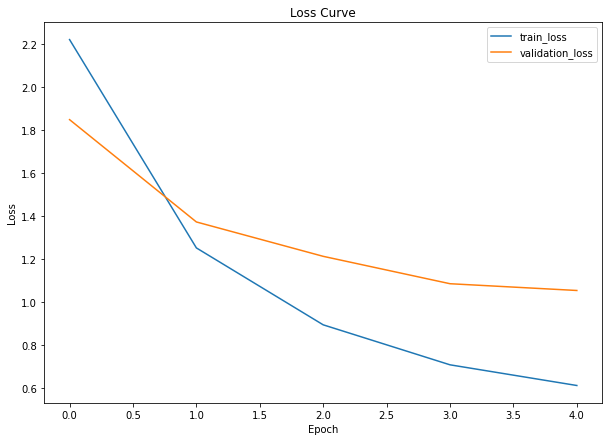

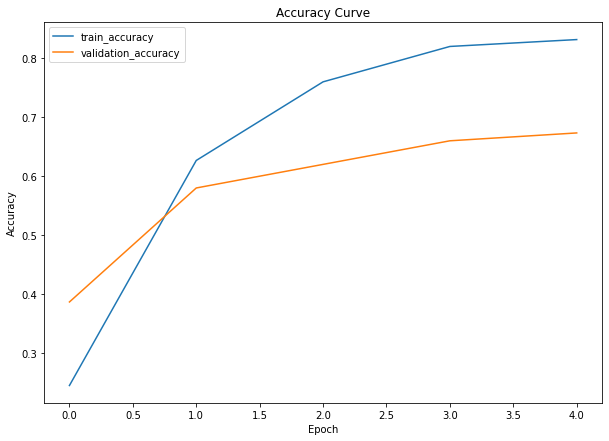

In [11]:
plot_loss_curves(history_mobilenet)

## 2. Name 3 different image classification models on TensorFlow Hub that we haven't used

1. Inception
2. VGG
3. Inception-ResNet

## 4. What is the current  best performing model on ImageNet?

CoCa: Contrastive Captioners